# IAPR project - Part 3

**Group members:**
    1- Gianni GIUSTO,
    2- Raphaël REIS NUNES,
    3- Christelle SCHNEUWLY

Classification with reasonnably balanced classes.

In [2]:
import numpy as np
import skimage.io
import os
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.morphology import closing, opening, square, disk
from skimage.color import label2rgb

In [3]:
# For deep learning
import torch

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
from torch import optim
from sklearn.metrics import confusion_matrix

In [4]:
data_folder = 'data'
data_filename = 'project-data'

In [5]:
train_path = os.path.join(data_folder, data_filename, 'images', 'train')
train_annotations_path = os.path.join(data_folder, data_filename, 'annotations', 'train')

test_path = os.path.join(data_folder, data_filename, 'images', 'test')
test_annotations_path = os.path.join(data_folder, data_filename, 'annotations', 'test')

## Useful functions

In [6]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [7]:
def sliding_window(img, window_size, step):
    '''
    Take an image as input and return a list of smaller images which correspond to sequences of the original image.
    The original image is scanned from top to bottom and left to right
    
    We will still follow Python indexing, such that:
        x = ↓ (height) 
        y = → (width)
    
    window_size: tuple [height, width]
    
    Input: original image (grayscale for the moment)
    Output: list of sub-images together with the location of that window [x_min, x_max, y_min, y_max]
            
                 y_min      y_max
                  |          |
          x_min _  __________
                  |          |
                  |          |
                  |          |
          x_max _ |__________|
          
            
    '''
    sub_imgs = []
    sub_imgs_location = []
    for x in range(0, img.shape[0], step):
        for y in range(0, img.shape[1], step):
            sub_img = img[x:x+window_size[0], y:y+window_size[1]]
            # Neglect for the moment border to have img of equal size
            if (sub_img.shape[0] == window_size[0]) and (sub_img.shape[1] == window_size[1]):
                sub_imgs.append(sub_img)
                
                x_min = x
                x_max = x + window_size[0] #img.shape[0]
                y_min = y
                y_max = y + window_size[1] #img.shape[1]
                
                sub_imgs_location.append([x_min, x_max, y_min, y_max])
    
    return sub_imgs, sub_imgs_location

In [8]:
def get_centers_and_boxes(xml_file):
    '''   
    Boxes format in xmls: [minc, minr, w, h]
    
    Using x ↓ and y = → : [y_min, x_min, w, h]
    
    Input: path to xml file
    Output: 
        - centers [x, y] = [row, col]
        - boxes [minc, minr, w, h]
        
    Note: box boundaries can easily be retrieved
        - x_max = x_min + h
        - y_max = y_min + w
    '''
    annotations_xml = parse_file(xml_file)
    
    centers = []
    boxes = []
    for anno in annotations_xml:
        box = anno['bbox']
        y_min = box[0]
        x_min = box[1]
        w = box[2]
        h = box[3]

        x_center = (x_min+h/2) 
        y_center = (y_min+w/2)
        
        centers.append([x_center, y_center])
        boxes.append(box)
    
    return centers, boxes

#### Visualization of varroas bounding boxes, centers and the scan window

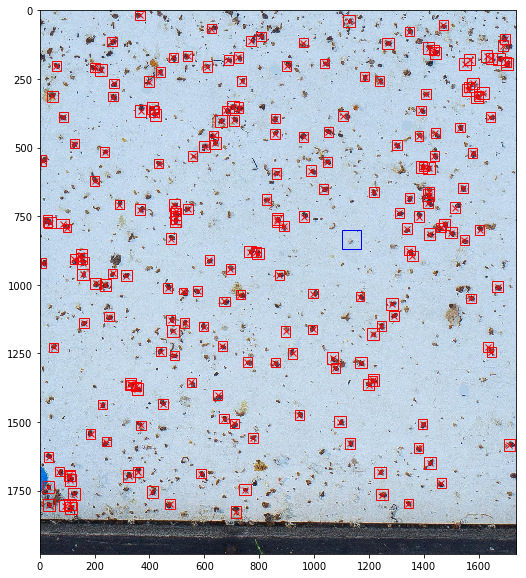

In [33]:
test_img_name = '58e7db24579e520d2470641c_32.00px_4' 
test_img = skimage.io.imread(os.path.join(test_path, test_img_name + '.jpg'))
test_img_gs = skimage.color.rgb2gray(test_img)

annotations = parse_file(test_annotations_path + '/' + test_img_name + '.xml')

test_centers, test_boxes = get_centers_and_boxes(test_annotations_path + '/' + test_img_name + '.xml')

# plot centers (red crosses) and boxes (red squares)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test_img)
for centre, box in zip(test_centers, test_boxes):
    ax.plot(centre[1], centre[0], 'xr') #plot uses x -> and y notation
    rect = mpatches.Rectangle((box[0], box[1]), box[2], box[3],
                linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

# visualize window dimension (blue)
my_window = mpatches.Rectangle((1100, 800), 70, 70,
                linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(my_window)

## Let's get started

**Approach**

**Build classifier = CNN**

The aim of this part is to detect the presence of varroa with the help of a CNN.

Criterion: if and only if the sub-window contains the entire varroa, attribute a label of 1 to this sub-image.
- Take the image of the test one after the other
- For each image get useful infos from the annotations
- For each image, use the *sliding window* method to obtain sub-images
- For each sub-image check whether a center is included in that image
    - If yes: check if the whole boxe is contained in that subimage
        - If yes: give a label 1 + add information about the bounding box!
        - If no: give a label 0
    - If no: give a label 0

Indeed, the key here is to define the target label $y$. Our network should output:
- the class of the object: [1, 0] (equal to asses the presence only as we have 2 classes)
- the bounding box information = 4 parameters that allow to fully characterize the box

Hence, the label vector $y$ could be of the form: [1, 0, minc, minr, w, h]

Note: all these subimages constitute our set to train the model with the corresponding labels.


**Training** aining is achieved using the loss. In practice, we will use:
- CrossEntropyLoss for the classification (binary classification)
- MSELoss for the bounding box informations

The backward is finally computed on the combination of these 2 losses.



In [9]:
'''
labels: contain class only
        - 1 if a varroa is present
        - 0 if no varroa (no object)

targets: contains all information such that
        - object present: [1, 0, minc, minr, w, h]
        - object not present: [0, 1, 0, 0, 0, 0]

dataset: contain all sub-images across all the test directory
         1 sub-image = 1 train sample
         (hence equal window size across the images, 
         it hence assumes that varroas have the same 'size'
         in all images. The validity of this assumption can
         be discussed. Can be solved by scaling images)
         
/!\ assumption: the sub-image contains only one object
'''

# Get names of all images in the test repo without extension
list_dir = os.listdir(test_annotations_path) 
names = []

for name in list_dir:
    n = os.path.splitext(name)[0]
    names.append(n)

    
dataset = []
labels = []
targets = []
for name in names:
    img = skimage.color.rgb2gray(skimage.io.imread(os.path.join(test_path, name + '.jpg'))) #TRAINTEST
        
    centers, boxes = get_centers_and_boxes(test_annotations_path + '/' + name + '.xml') #TRAINTEST
    
    sub_windows, sub_windows_location = sliding_window(img, [70, 70], 40) #80-20
    
    for im, loc in zip(sub_windows, sub_windows_location):
        # windows properties
        x_min = loc[0]
        x_max = loc[1]
        y_min = loc[2]
        y_max = loc[3]

        tmp = []
        for centre, box in zip(centers, boxes):
            x_center = centre[0]
            y_center = centre[1]

            # true boxes properties
            minc = box[0] #ymin of the box
            minr = box[1] #xmin
            w = box[2] 
            h = box[3]
            maxc = minc+w #ymax
            maxr = minr+h #xmax

            # Check center belong to the sub-image
            if (x_center < x_max) and (x_center > x_min) and (y_center < y_max) and (y_center > y_min):
                # Now check that the entire box belong to the sub image
                if (minr > x_min) and (maxr < x_max) and (minc > y_min) and (maxc < y_max):
                    tmp.append(1)
                else:
                    tmp.append(0)
            else:
                tmp.append(0)
        # Assess the presence of a whole object
        if np.sum(tmp) > 0:
            labels.append(1)
            targets.append([1, 0, minc, minr, w, h])
        else:
            labels.append(0)
            targets.append([0, 1, 0, 0, 0, 0]) #TODO: not sur it's a good idea to define the absence of bounding box by 0s
        
        # Store the image
        dataset.append(im)
        
    

## CNN

For practical reasons and so as to not overload the current notebook, useful functions can be found in the *utility.py* file. 

In [1]:
import utility

In [23]:
def compute_nb_errors(model, data_input, data_target):
    '''
    Cumulate the number of errors across each mini-batch.
    '''

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [30]:
def train_model(model, train_input, train_target, crit, mini_batch_size, monitor_params):
    '''
    crit: criterion. MSELoss() or CrossEntropyLoss().
    Cross entropy usually preferred for classification tasks.
    train_target: labels equired to compute the error.
    '''
    criterion = crit
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    nb_epochs = 80
    
    loss_storage = []
    error_storage = []
    accuracy_storage = []
    
    
    for e in range(nb_epochs):
        sum_loss = 0
        sum_error = 0
        sum_acc = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            
            output = model(train_input.narrow(0, b, mini_batch_size))
            
            ### Compute class from the output ###
            _, predicted_classes = torch.max(output.data, 1)
            
            ### Compute loss ###
            loss = criterion(output, train_target.view(train_target.size(0)).narrow(0, b, mini_batch_size))
            
            ### Compute train error ###
            nb_errors = 0
            for k in range(mini_batch_size):
                if train_target.data[b + k] != predicted_classes[k]:
                    nb_errors = nb_errors + 1
            
            sum_loss += loss.item() # compute loss for each mini batch for 1 epoch
            sum_error += nb_errors
            
            model.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Accuracy computed from the number of errors
        sum_acc = (train_input.size(0) - sum_error) / train_input.size(0)
        
        loss_storage.append(sum_loss)
        error_storage.append(sum_error)
        accuracy_storage.append(sum_acc)
                
        print('[epoch {:d}] loss: {:0.2f} error: {} accuracy: {:0.4f}'.format(e+1, sum_loss, sum_error, sum_acc))
        
    
    if monitor_params:
        return loss_storage, error_storage, accuracy_storage


In [25]:
def train_test_split_imgs(x, y, ratio, seed=0):
    '''
    Split the data in train, test arrays
    Inputs:
        - x: features vector = (nb_imgs, nb_rows, nb_cols)
        - y: labels
        - ratio: percetange of the data used for testing (between [0, 1[)
    Outputs:
        - x_train, x_test, y_train, y_test
    '''
    np.random.seed(seed)
    nb_samples = x.shape[0]
    idx_split = int(np.floor(ratio * nb_samples))
    
    my_permutation = np.random.permutation(nb_samples)
    x = x[my_permutation, :, :]
    y = y[my_permutation]
    
    x_train, x_test = x[:idx_split, :, :], x[idx_split:, :, :]
    y_train, y_test = y[:idx_split], y[idx_split:]
    
    return x_train, x_test, y_train, y_test


#### Network

Simple netowork consisting in:
- 2 convolutional layers
    - kernel_size_1 = 5, 16 output channels
    - kernel_size_2 = 3, 32 output channels
- 2 max_pooling
    - kernel_size_1 = 3
    - kernel_size_2 = 2
- 2 fully-connected layers
- ReLU used as activation function
- Dropout to reduce overfitting

As suggested previously, the total loss will be a combination of the loss from the classification process and from the localization process. 

Key: the **backward** is called once on the entire network!

Input: sub images of size [70, 70]

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(3200, 500)
        self.fc2 = nn.Linear(500, 2)
        self.dropout = nn.Dropout() 
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size = 3)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.view(-1, 3200)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

As a first step, we will just test the classification process, i.e. is there a varroa or not.

For the classification, input (i.e. sub-images) as well as labels (i.e. 1 or 0) need to be converted to *Tensors*.
- input shape: torch.Size([nb_samples, 1, h, w])
- label shape: torch.Size([nb_samples, 1])

Note that there are obviously much more 0-class (no object) than varroa in images. Hence both classes are heavily unbalanced. To solve the problem, we can count the number of positive labels and take a reasonnably proportionnal number of the other class.

Furhermore, the Matthews correlation coefficient (MCC) is a metric that helps to deal with unbalanced classes.

#### Main

In [12]:
# A bit of data manipulation to define properly our features vector with related labels
# Count the number of class 1
nb_varroas = np.sum(labels)
print('There are {} varroas in the test data'.format(nb_varroas))

# Convert to numpy, easier for manipulations
features = np.array(dataset)
varroas_imgs = features[np.where(labels), :, :]
varroas_imgs = varroas_imgs.reshape(nb_varroas, 70, 70)


There are 490 varroas in the test data


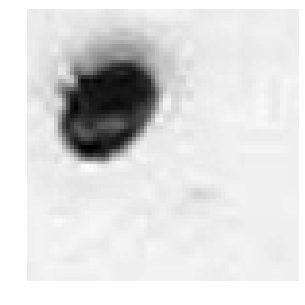

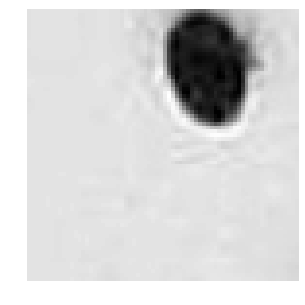

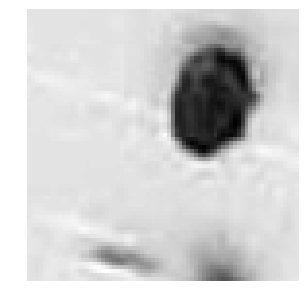

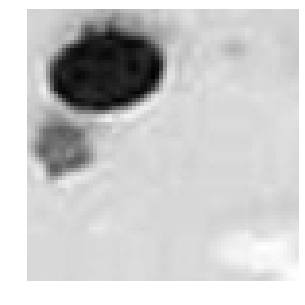

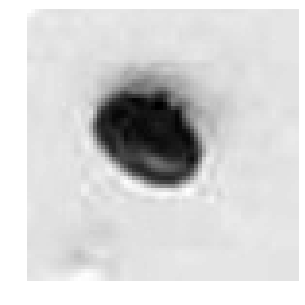

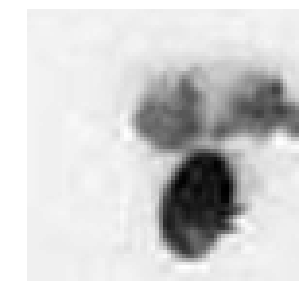

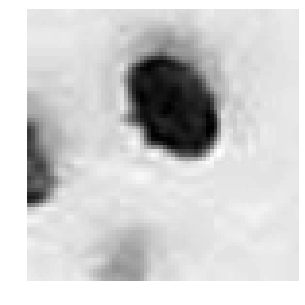

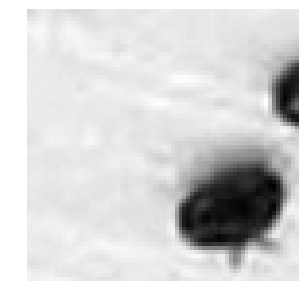

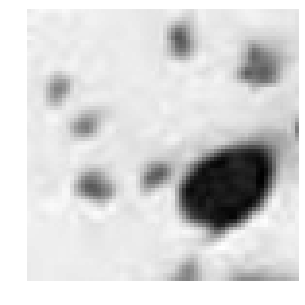

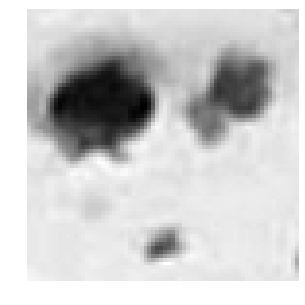

In [13]:
# Display few varroas
for i in range(10):
    v = varroas_imgs[i, :, :]
    plt.figure(figsize=(5,5))
    plt.imshow(v, cmap='gray')
    plt.axis('off')
    #plt.savefig('varroa_' + str(i) + '.jpg')

In [14]:
# Same process for the background
lab = np.array(labels)
background_imgs = features[np.where(lab==0), :, :]
background_imgs = background_imgs.reshape(background_imgs.shape[1], 70, 70)

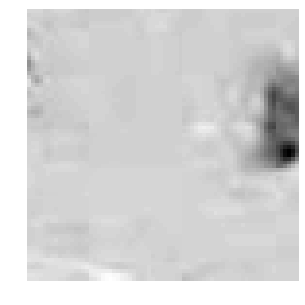

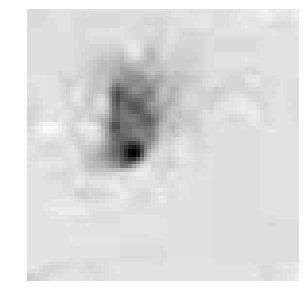

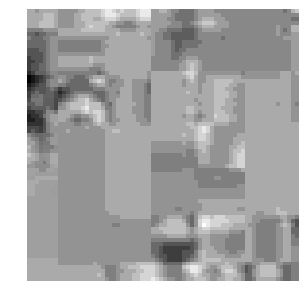

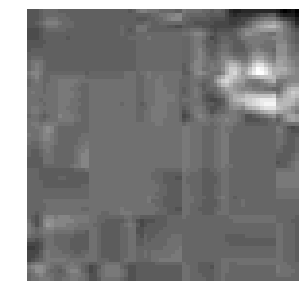

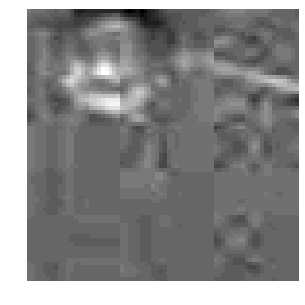

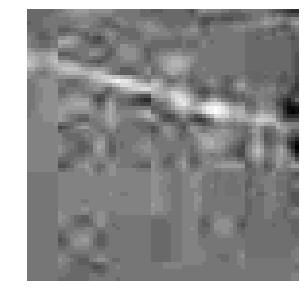

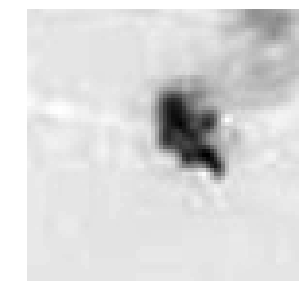

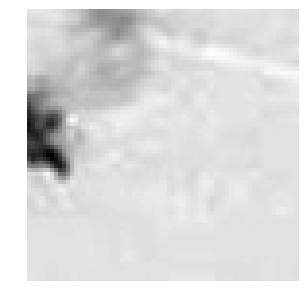

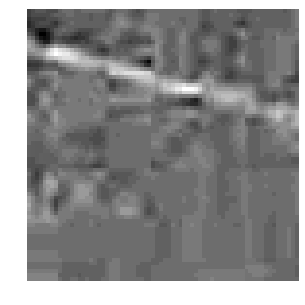

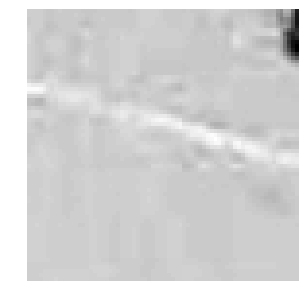

In [15]:
# Display few images for the background
for i in range(10):
    b = background_imgs[i+10, :, :]
    plt.figure(figsize=(5,5))
    plt.imshow(b, cmap='gray')
    plt.axis('off')
    #plt.savefig('background_' + str(i) + '.jpg')

In [16]:
# Select a reasonnable number of background images (let's say 1510)
# Shuffle background array and take the 1500 first images
n = 1510

permutations = np.random.permutation(background_imgs.shape[0])
background_subset = background_imgs[permutations, :, :]
background_subset = background_subset[:n, :, :]

# Builf feature vector
features_subset = np.concatenate((background_subset, varroas_imgs), axis=0)

# Build label vector
zero_labels = np.zeros(background_subset.shape[0])
one_labels = np.ones(varroas_imgs.shape[0])
labels_subset = np.concatenate((zero_labels, one_labels), axis=0)

print('Features vector shape: ', features_subset.shape)
print('labels vector shape:', labels_subset.shape)

Features vector shape:  (2000, 70, 70)
labels vector shape: (2000,)


Note: we have our sub-train data in order (i.e. 0 first, then 1) but the *train_test_split_imgs* methos will allow to shuffle this array.

In [26]:
train_input, test_input, train_target, test_target = train_test_split_imgs(features_subset, labels_subset, 0.80)

#Convert to tensors
train_input = torch.Tensor(train_input)
test_input = torch.Tensor(test_input)
train_target = torch.Tensor(train_target).long()
test_target = torch.Tensor(test_target).long()

train_input = train_input.view(train_input.shape[0], 1, train_input.shape[1], train_input.shape[2])
test_input = test_input.view(test_input.shape[0], 1, test_input.shape[1], test_input.shape[2])

# Sanity check
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

torch.Size([1600, 1, 70, 70])
torch.Size([1600])
torch.Size([400, 1, 70, 70])
torch.Size([400])


In [31]:
mini_batch_size = 100
model = Net()
crit = nn.CrossEntropyLoss()

losses_, errors_, accuracies_ = train_model(model, train_input, train_target, crit, mini_batch_size, True)

nb_train_errors = compute_nb_errors(model, train_input, train_target)

model.train(False)
nb_test_errors = compute_nb_errors(model, test_input, test_target)

print('Train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                      nb_train_errors, train_input.size(0)))
print('Test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
           
                                           nb_test_errors, test_input.size(0)))


[epoch 1] loss: 10.00 error: 431 accuracy: 0.7306
[epoch 2] loss: 9.15 error: 402 accuracy: 0.7488
[epoch 3] loss: 8.81 error: 402 accuracy: 0.7488
[epoch 4] loss: 8.29 error: 396 accuracy: 0.7525
[epoch 5] loss: 7.34 error: 350 accuracy: 0.7812
[epoch 6] loss: 6.66 error: 307 accuracy: 0.8081
[epoch 7] loss: 5.94 error: 276 accuracy: 0.8275
[epoch 8] loss: 4.98 error: 226 accuracy: 0.8588
[epoch 9] loss: 4.70 error: 204 accuracy: 0.8725
[epoch 10] loss: 4.14 error: 166 accuracy: 0.8962
[epoch 11] loss: 3.64 error: 161 accuracy: 0.8994
[epoch 12] loss: 3.50 error: 139 accuracy: 0.9131
[epoch 13] loss: 3.06 error: 128 accuracy: 0.9200
[epoch 14] loss: 2.98 error: 111 accuracy: 0.9306
[epoch 15] loss: 2.87 error: 114 accuracy: 0.9287
[epoch 16] loss: 2.87 error: 102 accuracy: 0.9363
[epoch 17] loss: 2.60 error: 99 accuracy: 0.9381
[epoch 18] loss: 2.72 error: 107 accuracy: 0.9331
[epoch 19] loss: 2.68 error: 102 accuracy: 0.9363
[epoch 20] loss: 2.67 error: 111 accuracy: 0.9306
[epoch 21

In [32]:
# Confusion matrix
test_output = model(test_input)
_, predicted_test_classes = torch.max(test_output.data, 1)


tn, fp, fn, tp = confusion_matrix(test_target.view(test_target.size(0)).numpy().tolist(), 
                                  predicted_test_classes.numpy().tolist()).ravel()


mcc = (tp*tn - fp*fn) / (np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * (precision * recall) / (precision + recall)

print('MCC: {:0.2f} \nPrecision: {:0.2f} \nRecall: {:0.2f} \nF-score: {:0.2f}'.format(mcc, precision, recall, f_score))
print('tn: {:0.2f} \nfp: {:0.2f} \nfn: {:0.2f} \ntp: {:0.2f}'.format(tn, fp, fn, tp))

MCC: 0.82 
Precision: 0.77 
Recall: 0.97 
F-score: 0.86
tn: 287.00 
fp: 25.00 
fn: 3.00 
tp: 85.00


**Conclusion :** The obtained results are quite satisfactory as we are working here on a small subset (50 images and approximatively 500 varroas). The model fed with the entire train set would achieve better performance and boxes would be detected with accuracy. Due to computational cost and because the RAM was completely occluded when running over the training set, trials were limited to the test set. The above code could be optimised so as not to store the entire images but by passing small subsets of images, chunck by chunck, to the model in order to avoid memory issues.

The main conclusion that can be drawn here is that Convolutional Neural Networks provide a powerful tool to detect the presence of a given object and are hence often used in the literature in object classification as well as localization tasks. It turns out to be more efficient compared to classical methods such as detector or basic segmentation. The main drawback is that it requires lots of data and yields higher computational time than other methods.